<h3>In this notebook I try clustering SAM verbatims using advanced machine learning techniques</h3>
<h4>Lessons learned:</h4>
1. I first coded emojies (like :), =), ((, etc.) as a separate feature, but rejected this idea, because:  

     - There are only 15 verbatims with emojies out of 5.8k  
     - This feature becomes too defining, forming "emoji" clusters
     
2. I dropped out all verbatims with no practical meaning (i.e. including only brand names, stopwords, punctuation and word _корм_)

Start with loading the required libraries.

In [7]:
# Working with files, tables and vectors
import pandas as pd
import numpy as np
import os
import sys
import wget
import zipfile
from collections import Counter
import pickle

# Visualizations
import seaborn as sns
from plotly import tools
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Working with texts
from gensim.models import Word2Vec
import gensim
import nltk
from nltk.corpus import stopwords
import string
from ufal.udpipe import Model, Pipeline
import re
from typing import List


# Models
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA

# Utility
from time import time
from tqdm._tqdm_notebook import tqdm_notebook

In [2]:
files = [file  for file in os.listdir() if file.endswith('.xls')]
print('There are %i SAM files in folder:\n'%len(files),'\n '.join(files))

There are 2 SAM files in folder:
 SAM 2019 verbatims cats.xls
 SAM 2019 verbatims dogs.xls


### Reading files

In [3]:
cats = pd.read_excel(files[0], encoding='utf-16', header=None, skiprows=1)
cats.columns = ['brand','verbatim']
cats['category'] = 'CAT'

dogs = pd.read_excel(files[1], encoding='utf-16', header=None, skiprows=1)
dogs.columns = ['brand','verbatim']
dogs['category'] = 'DOG'

df = pd.concat([cats,dogs], sort=False, ignore_index=True)
print('Combined data frame contains %i verbatims: %i for Cats and %i for Dogs.\n\nBrand split:\n'%
      (len(df),len(df[df.category=='CAT']),len(df[df.category=='DOG'])),
      round(df.brand.value_counts(dropna=False)/len(df)*100,1).astype(str)+"%")

Combined data frame contains 5775 verbatims: 3099 for Cats and 2676 for Dogs.

Brand split:
 Royal Canin    11.9%
Purina One     11.8%
Perfect Fit    11.7%
Sheba           6.1%
Whiskas         6.1%
Felix           6.1%
Gourmet         5.9%
Kitekat         5.9%
Eukanuba        5.9%
Pedigree        5.9%
Pro Plan        5.8%
Friskies        5.8%
Chappi          5.7%
Cesar           5.6%
Name: brand, dtype: object


__Observation:__ questionnaire was definately quoted having same number of respondents for each brand. We observe twice more answers for RC, PO and PF because they are presented in both CAT and DOG categories.

### Text pre-processing
In order to work with natural text, we need some kind of number representation of sentences.  
This representation shall be unique for each text, but close by meaning verbatims shall have close representation for clustering.  
In order to achieve this, we'll use Word2Vec technique.

__But before we transform words into vector representations, we need to lemmatize words (return them into primary form), remove punctuation and remove stopwords, brand names. This is called text pre-processing__

In [136]:
# Here we just load a prepared list of stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moyseand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We'll use [RusVectores preprocessing algorithms](https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb) for text preprocessing with addition of a couple of our euristics (removing stopwords and brand names)  
__First things first! Define preprocessing functions...__

In [202]:
def num_replace(word):
    newtoken = 'x' * len(word)
    return newtoken


def clean_token(token, misc):
    """
    :param token:  токен (строка)
    :param misc:  содержимое поля "MISC" в CONLLU (строка)
    :return: очищенный токен (строка)
    """
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    """
    :param lemma: лемма (строка)
    :param pos: часть речи (строка)
    :return: очищенная лемма (строка)
    """
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma


def list_replace(search, replacement, text):
    search = [el for el in search if el in text]
    for c in search:
        text = text.replace(c, replacement)
    return text


def unify_sym(text):  # принимает строку в юникоде
    text = list_replace \
        ('\u00AB\u00BB\u2039\u203A\u201E\u201A\u201C\u201F\u2018\u201B\u201D\u2019', '\u0022', text)

    text = list_replace \
        ('\u2012\u2013\u2014\u2015\u203E\u0305\u00AF', '\u2003\u002D\u002D\u2003', text)

    text = list_replace('\u2010\u2011', '\u002D', text)

    text = list_replace \
            (
            '\u2000\u2001\u2002\u2004\u2005\u2006\u2007\u2008\u2009\u200A\u200B\u202F\u205F\u2060\u3000',
            '\u2002', text)

    text = re.sub('\u2003\u2003', '\u2003', text)
    text = re.sub('\t\t', '\t', text)

    text = list_replace \
            (
            '\u02CC\u0307\u0323\u2022\u2023\u2043\u204C\u204D\u2219\u25E6\u00B7\u00D7\u22C5\u2219\u2062',
            '.', text)

    text = list_replace('\u2217', '\u002A', text)

    text = list_replace('…', '...', text)

    text = list_replace('\u2241\u224B\u2E2F\u0483', '\u223D', text)

    text = list_replace('\u00C4', 'A', text)  # латинская
    text = list_replace('\u00E4', 'a', text)
    text = list_replace('\u00CB', 'E', text)
    text = list_replace('\u00EB', 'e', text)
    text = list_replace('\u1E26', 'H', text)
    text = list_replace('\u1E27', 'h', text)
    text = list_replace('\u00CF', 'I', text)
    text = list_replace('\u00EF', 'i', text)
    text = list_replace('\u00D6', 'O', text)
    text = list_replace('\u00F6', 'o', text)
    text = list_replace('\u00DC', 'U', text)
    text = list_replace('\u00FC', 'u', text)
    text = list_replace('\u0178', 'Y', text)
    text = list_replace('\u00FF', 'y', text)
    text = list_replace('\u00DF', 's', text)
    text = list_replace('\u1E9E', 'S', text)

    currencies = list \
            (
            '\u20BD\u0024\u00A3\u20A4\u20AC\u20AA\u2133\u20BE\u00A2\u058F\u0BF9\u20BC\u20A1\u20A0\u20B4\u20A7\u20B0\u20BF\u20A3\u060B\u0E3F\u20A9\u20B4\u20B2\u0192\u20AB\u00A5\u20AD\u20A1\u20BA\u20A6\u20B1\uFDFC\u17DB\u20B9\u20A8\u20B5\u09F3\u20B8\u20AE\u0192'
        )

    alphabet = list \
            (
            '\t\n\r абвгдеёзжийклмнопрстуфхцчшщьыъэюяАБВГДЕЁЗЖИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ,.[]{}()=+-−*&^%$#@!~;:0123456789§/\|"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ')

    alphabet.append("'")

    allowed = set(currencies + alphabet)

    cleaned_text = [sym for sym in text if sym in allowed]
    cleaned_text = ''.join(cleaned_text)

    return cleaned_text

def process(pipeline, text='строчка текста или вербатим', keep_pos=True, keep_punct=False):
    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN ')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

def tag_ud(model, text=['Текст нужно передать функции в виде строки!'], stoplist=[None]):
    process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
    result = []
    #print('Processing input...', file=sys.stderr)
    for line in text:
        output = process(process_pipeline, text=line)
        result.append([w for w in output if w.split('_')[0] not in stoplist])
    return result

Download preprocessing model

In [203]:
udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
modelfile = wget.download(udpipe_url)

100% [........................................................................] 40616122 / 40616122

In [204]:
model_pp = Model.load(modelfile)

rus_brands = ['вискас', "пурина","гурмэ","гурме","фрискис","фрискиз","феликс","шеба","китекэт","китекет","роял","канин",
             "педигри","цезарь","екануба","план","чаппи","чапи",'whiskas','purina','gourmet','friskies','felix','sheba',
              'kitekat','royal','canin','pedigree','cesar','eukanuba','plan','chappi','шеб','гурм','пурин']
petfood = ['корм','корма','корму','кормов']
stop_list = [b.lower() for b in df.brand.unique().tolist()]+rus_brands+stopwords.words('russian')+petfood

#### Example of transforming sentences into lemma_tags

In [205]:
text = ['Шла Саша по шоссе и сосала сушку', 'Ваша киска купила бы Вискас!', 'И когда же меня отпустит?!']
for t,m in zip(text, tag_ud(model_pp, text, stoplist=stop_list)):
    print('\nFROM: \t%s \nTO: \t%s\n'%(t,m))


FROM: 	Шла Саша по шоссе и сосала сушку 
TO: 	['идти_VERB', 'саша_PROPN ', 'шоссе_NOUN', 'сосать_VERB', 'сушка_NOUN']


FROM: 	Ваша киска купила бы Вискас! 
TO: 	['ваш_DET', 'киска_NOUN', 'покупать_VERB']


FROM: 	И когда же меня отпустит?! 
TO: 	['отпустить_VERB']



In [206]:
corpus = tag_ud(model_pp, text=df.verbatim.tolist(), stoplist=stop_list)
print('We transofrm verbatims from this:\t',df.verbatim[7],'\nInto this form:\t\t\t\t',corpus[7])

We transofrm verbatims from this:	 Маленький пакет, дороже чем Шеба 
Into this form:				 ['маленький_ADJ', 'пакет_NOUN', 'дорогой_ADV']


## Transform verbatims into vectors  
At first we need to apply a vector representation to each word in our corpus. We'll use a pre-trained model from RusVectores.  
### 1. Language model to transform words into vectors

At first we'll download the pre-trained language model [from web](https://rusvectores.org/ru/models/) __(608 mb with 788 mln. Russian words)__  

In [207]:
model_url = 'http://vectors.nlpl.eu/repository/11/182.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]

100% [......................................................................] 637613765 / 637613765

Than load this model for further usage

In [208]:
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

__Language Model Demonstration:__

In [209]:
word = 'запах_NOUN'
print('Five closest words to word "%s" by meaning'%word)
for i in model.most_similar(positive=[word], topn=5):
    print('\t',i[0])

Five closest words to word "запах_NOUN" by meaning
	 аромат_NOUN
	 запахнуть_NOUN
	 запах_VERB
	 сладковатый_ADJ
	 вонь_NOUN


In [210]:
print('Words "человек" and "кот" similarity index:',model.similarity('человек_NOUN', 'кот_NOUN'))
print('Words "собака" and "кот" similarity index:',model.similarity('собака_NOUN', 'кот_NOUN'))
print('Words "кошка" and "кот" similarity index:',model.similarity('кошка_NOUN', 'кот_NOUN'))

Words "человек" and "кот" similarity index: 0.2949688
Words "собака" and "кот" similarity index: 0.6683645
Words "кошка" and "кот" similarity index: 0.79970944


In [211]:
word_seq = 'яблоко_NOUN груша_NOUN виноград_NOUN банан_NOUN лимон_NOUN картофель_NOUN'
print('Find the extra word from sequence %s'%word_seq)
print('\t',model.doesnt_match(list('яблоко_NOUN груша_NOUN виноград_NOUN банан_NOUN лимон_NOUN картофель_NOUN'.split())))

Find the extra word from sequence яблоко_NOUN груша_NOUN виноград_NOUN банан_NOUN лимон_NOUN картофель_NOUN


C:\Users\moyseand\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:876: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



	 картофель_NOUN


In [212]:
print('Solve word equation: пицца - италия + россия = ... ',end='')
print(model.most_similar(positive=['пицца_NOUN', 'россия_NOUN'], negative=['италия_NOUN'])[0][0].split('_')[0])
print('Solve word equation: принцесса - женщина + мужчина = ... ',end='')
print(model.most_similar(positive=['принцесса_NOUN', 'мужчина_NOUN'], negative=['женщина_NOUN'])[0][0].split('_')[0])

Solve word equation: пицца - италия + россия = ... пончик
Solve word equation: принцесса - женщина + мужчина = ... принц


Amazing, isn't it!?

In [213]:
print('So using this model we transform each word into %i length vector, e.g. %s is transformed into:'
      %(len(model['кошка_NOUN']),'кошка_NOUN'))
print('\n',model['кошка_NOUN'])

So using this model we transform each word into 300 length vector, e.g. кошка_NOUN is transformed into:

 [-0.09146988 -0.03680679  0.5640818  -0.13506575 -0.05273217  0.0203202
  0.09470966  0.18095788 -0.33941442 -0.40593022  0.22244272 -0.38032877
  0.09965096  0.25958464  0.11123124  0.0957229  -0.2574702   0.33745646
 -0.11012153 -0.35463032 -0.37429446  0.15047209  0.23572047  0.36127257
  0.39690948  0.44735292 -0.384819   -0.22213784 -0.21714012 -0.28386652
  0.20175892 -0.0297009   0.03729468 -0.19982602  0.08388663  0.27886468
  0.3248729   0.1710524   0.38667145  0.05654548  0.1115386   0.07484031
  0.25621182  0.21626955  0.5671156   0.1803538   0.27771413  0.12650503
  0.29756844  0.33967328 -0.30523604 -0.09883922 -0.20641118  0.05530191
 -0.21554731  0.6416805  -0.30369496  0.10926969  0.28230238 -0.0339318
 -0.17656766  0.10406238 -0.21237458  0.18361393 -0.0351536   0.12424099
  0.27305225 -0.14574307  0.06026503 -0.03921887  0.08078577  0.2157292
  0.35922498 -0.31657

However, some words may still be absent in model vocabulary. And if these are the only words in a sentence, it will become empty. We have to exclude such sentences from calculation.

In [214]:
corpus = [[w for w in sent if w in model] for sent in corpus]

Lets label zero-length sentences (i.e. sentenses with only stopwords or brands in them)

In [215]:
df['cluster'] = [len(x)==0 for x in corpus]
df['cluster'] = df.cluster.apply(lambda x: 'nothing' if x else np.nan)
corpus = [x for x in corpus if len(x)!=0]

df_plot = (pd.DataFrame(data={'brand':df.brand.unique()})
           .merge(df.loc[df.cluster.isna(),['brand','category']]
                  .groupby('brand', as_index=False)
                  .count()
                  .rename(columns={'category':'meaning'}),how='left')
           .merge(df.loc[df.cluster=='nothing',['brand','category']]
                  .groupby('brand', as_index=False)
                  .count()
                  .rename(columns={'category':'nothing'}),how='left')
           .fillna(0)
           .sort_values('meaning'))

meaning = go.Bar(x = df_plot['meaning'], y = df_plot['brand'], text = df_plot['meaning'],
                orientation = 'h', textposition = 'auto', textfont = dict(size=16),
                marker = dict(color = 'orange'), name = 'Verbatims with meaning')
nothing = go.Bar(x = df_plot['nothing'], y = df_plot['brand'], text = df_plot['nothing'],
                orientation = 'h', textposition = 'auto', textfont = dict(size=16),
                marker = dict(color = 'grey'), name = 'Verbatims with no meaning')

data = [meaning, nothing]
layout = go.Layout(title = 'Share of verbatims with meaning by brand',barmode = 'stack',bargap = 0.15,
                   xaxis=dict(showgrid=False, showline=False, showticklabels=False,tickfont=dict(size=38)))
pyo.iplot(go.Figure(data=data, layout=layout))

In [216]:
print('Examples of verbatims with no meaning:')
for v in np.random.choice(df[df.cluster=='nothing'].verbatim.values, size=5, replace=False):
    print('\t%s'%v)

Examples of verbatims with no meaning:
	нет
	ничего
	Незнаю
	Качественно,но дороговато
	Спирт


Great! The majority of verbatims are available for clustering in each brand.

### 2. Word-Vectors into Verbatim-Vectors
There are several ways to calculate vector representation for whole sentences having vector representations for the containing words: one can use vector sum or average, but this way a lot of information is being lost.  
Much better approach is to through weihted sum using SIF weights. Put it simple, we devaluate not unique words (that appear in many sentences) and give more weight to unique words, as they are more defining for the exact verbatim. [For more information please refer to this article](https://openreview.net/pdf?id=SyK00v5xx).

In [217]:
# A SIMPLE BUT TOUGH TO BEAT BASELINE FOR SENTENCE EMBEDDINGS
# Sanjeev Arora, Yingyu Liang, Tengyu Ma
# Princeton University
# convert a list of sentence with word2vec items into a set of sentence vectors
def sentence_to_vec(sentence_list, word_weights, model, embedding_size=300, a: float=1e-3):
    sentence_set = []
    for sentence in sentence_list:
        vs = np.zeros(embedding_size)  # add all word2vec values into one vector for the sentence
        weights = np.zeros(embedding_size)
        for word in sentence:
            try:
                a_value = a / (a + word_weights[word])  # smooth inverse frequency, SIF
                weights= np.add(weights, a_value)
                vs = np.add(vs, np.multiply(a_value, model[word]))  # vs += sif * word_vector
            except:
                continue

        vs = np.divide(vs, weights)  # weighted average
        sentence_set.append(vs)  # add to our existing re-calculated set of sentences

    # calculate PCA of this sentence set
    pca = PCA()
    pca.fit(np.array(sentence_set))
    u = pca.components_[0]  # the PCA vector
    u = np.multiply(u, np.transpose(u))  # u x uT

    # resulting sentence vectors, vs = vs -u x uT x vs
    sentence_vecs = []
    for vs in sentence_set:
        sub = np.multiply(u,vs)
        sentence_vecs.append(np.subtract(vs, sub))

    return sentence_vecs

Calculate word weights:

In [218]:
counter_dict = dict(Counter([item for sublist in corpus for item in sublist]))
corpus_size = len(corpus)
word_weights = {k:v/corpus_size for (k,v) in counter_dict.items()}

train_data = sentence_to_vec(corpus, word_weights, model)

In [219]:
print('So we got %i verbatims embeded into %i-size vectors'%(np.shape(train_data)[0],np.shape(train_data)[1]))

So we got 4807 verbatims embeded into 300-size vectors


Let's check some random verbatims for the closest ones... We'll do it with vector cosine similarity.

In [220]:
def cos_similarity(vec1, vec2):
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot / (norm1*norm2)

def find_similar_verbatims(verbatims, verb_vectors, n_similar):
    verb_n = np.random.choice(len(verbatims))
    
    v = verbatims[verb_n]
    print('Finding %i similar verbatims for phraze:\n%s'%(n_similar, v))
    v_vec = verb_vectors[verb_n]
    sims = [cos_similarity(v_vec, i) for i in verb_vectors]
    temp = pd.DataFrame({'verbatims':verbatims,'sims':sims}).sort_values('sims', ascending=False)
    return temp[temp.verbatims!=v]['verbatims'].head(n_similar)

In [221]:
verbs = df[df.cluster!='nothing'].verbatim.values

In [228]:
find_similar_verbatims(verbs, train_data, 10)

Finding 10 similar verbatims for phraze:
тоже можно побаловать кошку


425                         иногда можно побаловать кошку
2078                                Это только побаловать
4590                              можно иногда побаловать
203                                            побаловать
12                 Буду покупать только чтобы побаловать.
4416              дороговато но побаловать можно(влажный)
3852    премиальная марка, чтобы побаловать своего пит...
3450                Элитный корм, чтобы побаловать собаку
3896    хорошее соотношение цены и качества чтобы поба...
42      Наверное, можно купить пакетик влажного корма,...
Name: verbatims, dtype: object

__Looks quite good, seems like our language model managed to derive some structure from verbatim!__

### So we've converted verbatims into 300-dimensional vectors 
### Let's look at our data

We'll reduce dimensions to 2 and look at vectors:

In [229]:
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=50)
t0 = time()
train_tsne = tsne.fit_transform(train_data)
t1 = time()
print('Completed in %.2g sec'%(t1-t0))

Completed in 64 sec


In [230]:
tsne_data = pd.DataFrame(train_tsne, columns=['one','two'])

traces = [go.Scatter(x = tsne_data['one'],
                     y = tsne_data['two'],
                     mode='markers',
                     marker = dict(size=3,opacity=0.8))]
layout = go.Layout(title = '300d to 2d T-SNE transformed Verbatim Vectors')
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

Looks pretty, doesn't it? :) The majority is wide-spread, but some zones show high density.

## Let's cluster it!
### At first we'll use a standart approach - KMeans. Lets choose number of clusters.

In [231]:
max_n_clusters = 20
inert = []
for k in tqdm_notebook(range(1, max_n_clusters+1)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_data)
    inertia = np.sqrt(kmeans.inertia_)
    inert.append(np.sqrt(kmeans.inertia_))

In [232]:
traces = [go.Scatter(x=list(range(1,len(inert)+1)), y=inert, mode='lines+markers')]
layout = go.Layout(title='KMeans Inertia Decay', xaxis={'title':'# clusters'}, yaxis={'showticklabels':False,'showline':False})
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

Using an 'Elbow-Rule' let's go with 8 clusters!
Now for stability we'll re-cluster the cluster centers...

In [233]:
n_cluster = 8

centers = []
for i in tqdm_notebook(range(50)):
    kmeans = KMeans(n_clusters=n_cluster, random_state=i).fit(train_data)
    centers.append(kmeans.cluster_centers_)

In [234]:
final_kmeans = KMeans(n_clusters=n_cluster).fit(np.vstack(centers))
preds = final_kmeans.predict(train_data)
df.loc[df.cluster!='nothing','cluster'] = preds
df.to_csv('clustered.csv',index=False)

Look at clusters:

In [235]:
tsne_data['cluster'] = preds
print(tsne_data['cluster'].value_counts())

traces = [go.Scatter(x = tsne_data[tsne_data.cluster==c]['one'],
                     y = tsne_data[tsne_data.cluster==c]['two'],
                     name='Cluster '+str(c),
                     mode='markers',
                     marker = dict(size=3,opacity=0.8))
         for c in tsne_data.cluster.unique()]
layout = go.Layout(title = '2-d T-SNE transformed Sentence Vectors with Clusters')
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

6    1800
2    1656
5     456
0     366
3     339
4      96
7      54
1      40
Name: cluster, dtype: int64


### Find 7 most "defining" verbatims for each cluster

In [236]:
tsne_data['cluster'].value_counts()

6    1800
2    1656
5     456
0     366
3     339
4      96
7      54
1      40
Name: cluster, dtype: int64

We observe that clusters are not equal: cluster 0 and 4 are quite large, while clusters 2, 3, 5 and 7 are small. It is a common result in verbatims clustering: the majority of people say similar things.  

We'll use a [_cosine similarity_](https://en.wikipedia.org/wiki/Cosine_similarity) to measure similarity between sencence vector representation and cluster center

In [237]:
clust = 0
for kcenter in final_kmeans.cluster_centers_:
    col_name = 'Def verbatims ' + str(clust)
    df[col_name] = 0
    df.loc[df.cluster!='nothing',col_name] = [cos_similarity(kcenter, v) for v in train_data]
    clust+=1

In [238]:
df['cluster_defining'] = df.apply(lambda x: x['Def verbatims 0'] if x['cluster']==0 else 
                                 (x['Def verbatims 1'] if x['cluster']==1 else
                                  (x['Def verbatims 2'] if x['cluster']==2 else
                                   (x['Def verbatims 3'] if x['cluster']==3 else
                                    (x['Def verbatims 4'] if x['cluster']==4 else
                                     (x['Def verbatims 5'] if x['cluster']==5 else
                                      (x['Def verbatims 6'] if x['cluster']==6 else
                                       (x['Def verbatims 7'] if x['cluster']==7 else 0))))))),axis=1)
df = df.drop([col for col in df.columns if col.startswith('Def')], axis=1)

Finally we get the following data frame, where `cluster_defining` column is opposite to distance to the cluster center.

In [239]:
df.to_csv('clustered_1.csv',index=False)

In [240]:
for clust in sorted(df[df.cluster!='nothing']['cluster'].unique()):
    print('Cluster %i size: %i'%(int(clust),len(df[df.cluster==clust])))
    print('Most defining verbatims:')
    temp = df.loc[df.cluster==clust,].sort_values('cluster_defining', ascending=False).verbatim.head(7)
    for i in temp:
        print('\t',i)
    print('\n')

Cluster 0 size: 366
Most defining verbatims:
	 Вкусная еда для моей кошки
	 Вкусная еда для кошек
	 Вкусная еда котам нраситсч
	 очень вкусная еда
	 Корм.обычная вкусная еда
	 Вкусная еда
	 Вкусная еда


Cluster 1 size: 40
Most defining verbatims:
	 дорого
	 дорого
	 дорого
	 дорого
	 дорого
	 дорого
	 дорого


Cluster 2 size: 1656
Most defining verbatims:
	 Хотелось бы, чтобы корм действительно заботился о здоровье животных. Собаки словами не могут нам передать свое отношение к нему, а из любви к хозяину, могут съесть и не очень привлекательный продукт.
	 Ничего не думаю, я не знакома с этой маркой
	 знаю как корм для кошек
	 Думаю, что это хорошая марка, но сама не покупала
	 Мой кот очень любит и еще нравится реклама
	 Хороший корм, кошке нравится
	 да ничего я о ней не думаю - качественный корм для кошек и собак и все


Cluster 3 size: 339
Most defining verbatims:
	 корм для собак и кошек
	 Корм для кошек и собак
	 корма для кошек и собак
	 Корм для собак и кошек
	 кошка, собака
	 

So we get following results:
- __Cluster 0__: tasty   
- __Cluster 1__: expensive    
- __Cluster 2__: _large mixed cluster_
- __Cluster 3__: for cats and dogs
- __Cluster 4__: advertizing   
- __Cluster 5__: about cat and colors on package
- __Cluster 6__: _another large mixed cluster_  
- __Cluster 7__: petfood segment

Id doesn't look like ideal clustering now, mostly because we have 2 large clusters that can't be defined precisely.  
Let's try a more complicated clustering approach...

### Alternative Clustering approach: EM alorithm for Gaussian Mixture Models
On T-SNE plot we see, that data is more likely to be formed in elliptoids, not just squares. Terefore a series of gaussians may provide a better cluster representation. At least it worth trying :)

In [241]:
bic = []
aic = []
gmm_train = np.array(train_data)
for n in tqdm_notebook(np.arange(1, 21)):
    mod = GMM(n, covariance_type='full', random_state=0).fit(gmm_train)
    bic.append(mod.bic(gmm_train))
    aic.append(mod.aic(gmm_train))

In [242]:
aic_bic_avg = np.array(pd.Series(aic) + pd.Series(bic))/2
n_clusters = np.arange(1, 21)

traces = [go.Scatter(x=n_clusters, y=bic, mode='lines+markers', name='BIC'),
          go.Scatter(x=n_clusters, y=aic, mode='lines+markers', name='AIC'),
          go.Scatter(x=n_clusters, y=aic_bic_avg, mode='lines+markers', name='average'),
          go.Scatter(x=n_clusters, y=np.ones(20)*np.min(aic_bic_avg), mode='lines', name='minimum of average', 
                     line={'dash':'dash','color':'grey'})]

layout = go.Layout(title='Choosing GMM number of clusters', 
                   yaxis={'showticklabels':False,'showline':False},
                   xaxis={'title':'# clusters'})

fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

In [243]:
print('Best choice for number of clusters is %i'%(np.argmin(aic_bic_avg)+1))

Best choice for number of clusters is 10


10 clusters seem to be the best choice

In [244]:
gmm_model = GMM(10, covariance_type='full', random_state=0).fit(train_data)

In [245]:
gmm_preds = gmm_model.predict(train_data)
gmm_preds_proba = gmm_model.predict_proba(train_data)
tsne_data['gmm_cluster'] = gmm_preds

In [246]:
df['gmm_cluster'] = df['cluster']
df['gmm_proba'] = 0
df.loc[df.gmm_cluster!='nothing','gmm_cluster'] = gmm_preds
df.loc[df.gmm_cluster!='nothing','gmm_proba'] = gmm_preds_proba.max(axis=1)

In [247]:
df.to_csv('clustered_gmm.csv',index=False)

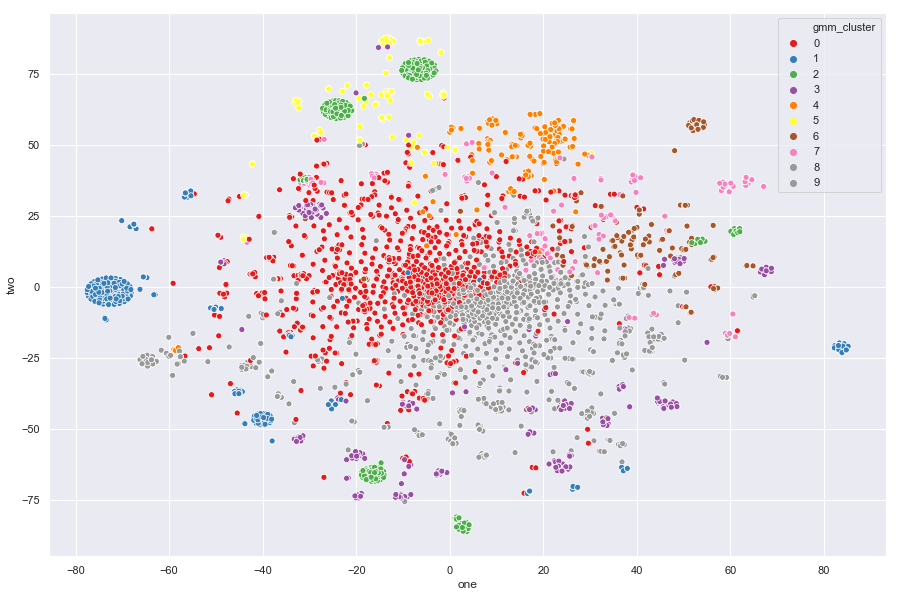

In [248]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x=tsne_data['one'], y=tsne_data['two'], hue=tsne_data['gmm_cluster'], 
                legend='full', palette='Set1')

In [249]:
for clust in sorted(df[df.gmm_cluster!='nothing']['gmm_cluster'].unique()):
    print('Cluster %i size: %i'%(int(clust),len(df[df.gmm_cluster==clust])))
    print('Most defining verbatims:')
    temp = df.loc[df.gmm_cluster==clust,].sort_values('gmm_proba', ascending=False).verbatim.head(15)
    probs = df.loc[df.gmm_cluster==clust,].sort_values('gmm_proba', ascending=False).gmm_proba.head(15)
    for i,j in zip(probs,temp):
        print('\t[%.1f]'%i,j)
    print('\n')

Cluster 0 size: 1252
Most defining verbatims:
	[1.0] Кот точно будет рад
	[1.0] качественный корм, подобранный специально по породам собак
	[1.0] Большая благородная собака
	[1.0] Не достаточно популярна, по остальному нужно смотреть насколько корм нравится собаке
	[1.0] Полезно,натурально, не навредит здоровью моей собаки
	[1.0] король
	[1.0] просто слышала, так как друзья кормят собаку этим кормом
	[1.0] Ничего не приходит на ум
	[1.0] Гадость, химия
	[1.0] Удивительно прекрасная реклама!
	[1.0] Благородное название
	[1.0] Видела рекламу
	[1.0] Широкий ассортимент продуктов. Благодаря данной марке мы познакомились с лакомством по уходу за зубами. Вызывает доверие. Чувствуется премиальность.
	[1.0] Недорого, однако не очень нравится моей собаке
	[1.0] Не знакома,может видела 1-2 раза


Cluster 1 size: 434
Most defining verbatims:
	[1.0] не знаю
	[1.0] Дорогая
	[1.0] Не слышал такую марку
	[1.0] НЕ ЗНАЮ
	[1.0]  я не знаю такой марки
	[1.0] дорого
	[1.0] не знаю
	[1.0] дорого
	[1.0] нич

There is a structure, but the results don't seem more meaningful than in KMeans clustering. So we'll stick to our initial approach.

## Clustering Level 2
So we decided to use 8-clusters KMeans model. But 2 clusters (2 and 6) are still quite ambigious. Let's take them out and cluster again! :)

At first we'll filter train_data to keep only vectors of clusters 2 and 6

In [250]:
df = df.drop(['gmm_cluster','gmm_proba'], axis=1)

Make a new sentence data corpus

In [251]:
verbs_sec = df[df.cluster.isin([2,6])].verbatim.tolist()
corpus_second = tag_ud(model_pp, text=verbs_sec, stoplist=stop_list)

And create new vectors

In [252]:
counter_dict = dict(Counter([item for sublist in corpus_second for item in sublist]))
corpus_size = len(corpus_second)
word_weights = {k:v/corpus_size for (k,v) in counter_dict.items()}

train_second = sentence_to_vec(corpus_second, word_weights, model)

In [253]:
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=50)
t0 = time()
train_tsne = tsne.fit_transform(train_second)
t1 = time()
print('Completed in %.2g sec'%(t1-t0))

Completed in 41 sec


In [254]:
tsne_second = pd.DataFrame(train_tsne, columns=['one','two'])

traces = [go.Scatter(x = tsne_second['one'],
                     y = tsne_second['two'],
                     mode='markers',
                     marker = dict(size=3,opacity=0.8))]
layout = go.Layout(title = '300d to 2d T-SNE transformed Verbatim Vectors')
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

And now to clustering. We'll stick only to K-Means this time.

In [255]:
max_n_clusters = 20
inert = []
for k in tqdm_notebook(range(1, max_n_clusters+1)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_second)
    inertia = np.sqrt(kmeans.inertia_)
    inert.append(np.sqrt(kmeans.inertia_))

In [256]:
traces = [go.Scatter(x=list(range(1,len(inert)+1)), y=inert, mode='lines+markers')]
layout = go.Layout(title='KMeans Inertia Decay', xaxis={'title':'# clusters'}, yaxis={'showticklabels':False,'showline':False})
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

11 clusters is our choice!

In [257]:
n_cluster = 11

centers = []
for i in tqdm_notebook(range(50)):
    kmeans = KMeans(n_clusters=n_cluster, random_state=i).fit(train_second)
    centers.append(kmeans.cluster_centers_)

In [258]:
final_kmeans = KMeans(n_clusters=n_cluster).fit(np.vstack(centers))
preds = final_kmeans.predict(train_second)+100 #add 100 to identify 2nd level clusters from 1st level ones

Look at clusters:

In [259]:
tsne_second['cluster'] = preds
print(tsne_second['cluster'].value_counts())

traces = [go.Scatter(x = tsne_second[tsne_second.cluster==c]['one'],
                     y = tsne_second[tsne_second.cluster==c]['two'],
                     name='Cluster '+str(c),
                     mode='markers',
                     marker = dict(size=3,opacity=0.8))
         for c in tsne_second.cluster.unique()]
layout = go.Layout(title = '2-d T-SNE transformed Sentence Vectors with Clusters')
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

102    1521
100    1091
105     209
103     164
110     151
101      92
106      62
108      58
104      46
109      31
107      31
Name: cluster, dtype: int64


In [260]:
df.loc[df.cluster.isin([2,6]),'cluster'] = preds
df.to_csv('clustered_2.csv',index=False)

Show 10 most defining verbatims for clusters.

In [262]:
clust = 0
for kcenter in final_kmeans.cluster_centers_:
    col_name = 'Def verbatims ' + str(clust)
    df[col_name] = 0
    df.loc[df.cluster.isin(list(range(100,111))),col_name] = [cos_similarity(kcenter, v) for v in train_second]
    clust+=1

In [263]:
df['cluster_defining_second'] = df.apply(lambda x: x['Def verbatims 0'] if x['cluster']==0 else 
                                 (x['Def verbatims 1'] if x['cluster']==1 else
                                  (x['Def verbatims 2'] if x['cluster']==2 else
                                   (x['Def verbatims 3'] if x['cluster']==3 else
                                    (x['Def verbatims 4'] if x['cluster']==4 else
                                     (x['Def verbatims 5'] if x['cluster']==5 else
                                      (x['Def verbatims 6'] if x['cluster']==6 else
                                       (x['Def verbatims 7'] if x['cluster']==7 else
                                        (x['Def verbatims 8'] if x['cluster']==8 else
                                         (x['Def verbatims 9'] if x['cluster']==9 else
                                          (x['Def verbatims 10'] if x['cluster']==10 else 0)))))))))),axis=1)
df = df.drop([col for col in df.columns if col.startswith('Def')], axis=1)

In [264]:
for clust in sorted(df[df.cluster.isin(list(range(100,111)))]['cluster'].unique()):
    print('Cluster %i size: %i'%(int(clust),len(df[df.cluster==clust])))
    print('Most defining verbatims:')
    temp = df.loc[df.cluster==clust,].sort_values('cluster_defining_second', ascending=False).verbatim.head(10)
    for i in temp:
        print('\t',i)
    print('\n')

Cluster 100 size: 1091
Most defining verbatims:
	 Кот точно будет рад
	 не пробовали
	 Недорого, однако не очень нравится моей собаке
	 супер, но дорого. я довольна этой маркой
	 видела рекламу
	 Забота о здоровье питомца
	 Что-то новое
	 Благородное название
	 Корм дл
	 Быстро, вкусно, полезно


Cluster 101 size: 92
Most defining verbatims:
	 Дешёвый корм
	 Можно сэкономить
	 дешево
	 Дорого
	 дешево
	 Дорого
	 Хороший корм, можно сделать его подешевле, покупать будут больше
	 хороший корм но я покупаю из их линейки только дороже
	 Дорого
	 дешевле вискаса


Cluster 102 size: 1521
Most defining verbatims:
	 Корм эконом класса низкого качества
	 не думаю, что слишком отличается от всех остальных марок
	 Марка корма для собак и кошек
	 Недорогой! Пёсику нравится!
	 Корм для собак разных пород и вкусовых предпочтений
	 Для данной ценовой категории, считаю, что корм достаточно не плохого качества, приятные упаковки, корм производит вид более хорошего, по сравнению стем же дпрлинг, педигри

So we get following results:
- __Cluster 100__: _large mixed cluster_ 
- __Cluster 101__: pricing concerns
- __Cluster 102__: _another large mixed cluster_  
- __Cluster 103__: good petfood
- __Cluster 104__: quality
- __Cluster 105__: don't know about it
- __Cluster 106__: quality brand
- __Cluster 107__: useful, healthy
- __Cluster 108__: expensive
- __Cluster 109__: hard to say something
- __Cluster 110__: premium, elite

Seems like we will be merging some clusters later.  
Now we can see that we still have one cluster that is very diverse and not homogenious. We will do the last, 3rd attemp to group those verbatims somehow.

## Clustering Level 3
So we added another 9 clusters to previous 6, but clusters 100 and 102 are still very diverse. Let's try clustering them again!

In [265]:
verbs_3 = df[df.cluster.isin([100,102])].verbatim.tolist()
corpus_3 = tag_ud(model_pp, text=verbs_3, stoplist=stop_list)

counter_dict = dict(Counter([item for sublist in corpus_3 for item in sublist]))
corpus_size = len(corpus_3)
word_weights = {k:v/corpus_size for (k,v) in counter_dict.items()}

train_3 = sentence_to_vec(corpus_3, word_weights, model)

In [266]:
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=50)
t0 = time()
train_tsne = tsne.fit_transform(train_3)
t1 = time()
print('Completed in %.2g sec'%(t1-t0))

Completed in 30 sec


In [267]:
tsne_3 = pd.DataFrame(train_tsne, columns=['one','two'])

traces = [go.Scatter(x = tsne_3['one'],
                     y = tsne_3['two'],
                     mode='markers',
                     marker = dict(size=3,opacity=0.8))]
layout = go.Layout(title = '300d to 2d T-SNE transformed Verbatim Vectors')
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

It is hard to find clusters here. Only few zones with something that may form clusters. Lets check it.

In [268]:
max_n_clusters = 20
inert = []
for k in tqdm_notebook(range(1, max_n_clusters+1)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(train_3)
    inertia = np.sqrt(kmeans.inertia_)
    inert.append(np.sqrt(kmeans.inertia_))

traces = [go.Scatter(x=list(range(1,len(inert)+1)), y=inert, mode='lines+markers')]
layout = go.Layout(title='KMeans Inertia Decay', xaxis={'title':'# clusters'}, yaxis={'showticklabels':False,'showline':False})
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

In [269]:
n_cluster = 5

centers = []
for i in tqdm_notebook(range(50)):
    kmeans = KMeans(n_clusters=n_cluster, random_state=i).fit(train_3)
    centers.append(kmeans.cluster_centers_)

In [270]:
final_kmeans = KMeans(n_clusters=n_cluster).fit(np.vstack(centers))
preds = final_kmeans.predict(train_3)+200 #add 200 to identify 3rd level clusters from 1st and 2nd ones

tsne_3['cluster'] = preds
print(tsne_3['cluster'].value_counts())

traces = [go.Scatter(x = tsne_3[tsne_3.cluster==c]['one'],
                     y = tsne_3[tsne_3.cluster==c]['two'],
                     name='Cluster '+str(c),
                     mode='markers',
                     marker = dict(size=3,opacity=0.8))
         for c in tsne_3.cluster.unique()]
layout = go.Layout(title = '2-d T-SNE transformed Sentence Vectors with Clusters')
fig = go.Figure(data=traces, layout=layout)
pyo.iplot(fig)

201    1013
203     831
202     641
200     113
204      14
Name: cluster, dtype: int64


In [272]:
df.loc[df.cluster.isin([100,102]),'cluster'] = preds
df.to_csv('clustered.csv',index=False)

clust = 0
for kcenter in final_kmeans.cluster_centers_:
    col_name = 'Def verbatims ' + str(clust)
    df[col_name] = 0
    df.loc[df.cluster.isin(list(range(200,205))),col_name] = [cos_similarity(kcenter, v) for v in train_3]
    clust+=1
    
df['cluster_defining_third'] = df.apply(lambda x: x['Def verbatims 0'] if x['cluster']==0 else 
                                 (x['Def verbatims 1'] if x['cluster']==1 else
                                  (x['Def verbatims 2'] if x['cluster']==2 else
                                   (x['Def verbatims 3'] if x['cluster']==3 else
                                      (x['Def verbatims 4'] if x['cluster']==4 else 0)))),axis=1)
df = df.drop([col for col in df.columns if col.startswith('Def')], axis=1)

for clust in sorted(df[df.cluster.isin(list(range(200,205)))]['cluster'].unique()):
    print('Cluster %i size: %i'%(int(clust),len(df[df.cluster==clust])))
    print('Most defining verbatims:')
    temp = df.loc[df.cluster==clust,].sort_values('cluster_defining_second', ascending=False).verbatim.head(10)
    for i in temp:
        print('\t',i)
    print('\n')

Cluster 200 size: 113
Most defining verbatims:
	 надежная
	 доступность
	 качественный и доступный корм
	 удобная упаковка
	 доступная по цене
	 Популярная
	 известность
	 популярный корм
	 Качественный корм по доступной цене
	 популярный корм


Cluster 201 size: 1013
Most defining verbatims:
	 Кот точно будет рад
	 бывает разных видов,
	 видела рекламу
	 Недорого, однако не очень нравится моей собаке
	 Видела рекламу
	 Удивительно прекрасная реклама!
	 Гадость, химия
	 Ничего не приходит на ум
	 просто слышала, так как друзья кормят собаку этим кормом
	 любит моя собака


Cluster 202 size: 641
Most defining verbatims:
	 этот корм относится к эконом классу, но мне кажется это больше похоже на премиум класс
	 Хороший корм. Собаке нравится.
	 одобрено диетологами и ветеринарами
	 видела ее в фильме про Бетховена
	 Для данной ценовой категории, считаю, что корм достаточно не плохого качества, приятные упаковки, корм производит вид более хорошего, по сравнению стем же дпрлинг, педигрии и т

Yay! It worked! We still have mixed type clusters, but we got some new stuff!

So we get following results:
- __Cluster 200__: mass market, value for money
- __Cluster 201__: _large mixed cluster_
- __Cluster 202__: _another large mixed cluster_
- __Cluster 203__: _another large mixed cluster_
- __Cluster 204__: OK

__It seems like we managed to derive all structure from verbatims that we could by mathimatical means. Let's analyze what we got here...__

- __Cluster 0__: tasty   
- __Cluster 1__: expensive    
- __Cluster 3__: for cats and dogs
- __Cluster 4__: advertizing   
- __Cluster 5__: about cat and colors on package 
- __Cluster 7__: petfood segment
- __Cluster 101__: pricing concerns
- __Cluster 103__: good petfood
- __Cluster 104__: quality
- __Cluster 105__: don't know about it
- __Cluster 106__: quality brand
- __Cluster 107__: useful, healthy
- __Cluster 108__: expensive
- __Cluster 109__: hard to say something
- __Cluster 110__: premium, elite
- __Cluster 200__: mass market, value for money
- __Cluster 201__: _large mixed cluster_
- __Cluster 202__: _another large mixed cluster_
- __Cluster 203__: _another large mixed cluster_
- __Cluster 204__: OK

Lets combine them a little bit:  
- 201, 202 and 203 -> unclustered
- 1, 101, 108, 200 -> pricing concerns
- 103, 104, 106, 204 -> good quality
- 3, 5, 7 - pure facts
- 105, 109 - don't know

In [274]:
df['cluster'] = df['cluster'].astype(str)
sorted(df['cluster'].unique())

['0',
 '1',
 '101',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '200',
 '201',
 '202',
 '203',
 '204',
 '3',
 '4',
 '5',
 '7',
 'nothing']

In [275]:
cluster_names = ['tasty','pricing concerns','pricing concerns','good quality','good quality','dont know','good quality',
                 'useful, healthy','pricing concerns','dont know','premium, elite','pricing concerns','unclustered',
                 'unclustered','unclustered','good quality','pure facts','saw advertizing','pure facts','pure facts',
                 'nothing']
 
df = df.merge(pd.DataFrame({'cluster':sorted(df['cluster'].unique()),'cluster_names':cluster_names}), how='left')

In [276]:
df = df.drop(['cluster_defining','cluster_defining_second','cluster_defining_third','cluster'], axis=1)

## Analyzing Clusters

In [282]:
clust_to_remove = ['unclustered','nothing','dont know','pure facts']
df_cat = (df.loc[df['cluster_names'].isin(clust_to_remove)==False,['category','cluster_names','brand']]
          .groupby(['category','cluster_names'], as_index=False).count().sort_values('cluster_names'))

fig = {
    'data':[
        {
            'values':df_cat.loc[df_cat.category=='CAT','brand'],
            'labels':df_cat.loc[df_cat.category=='CAT','cluster_names'],
            'domain':{'column':0},
            'name':'CAT',
            'hole':.4,
            'type':'pie'
        },
        {
            'values':df_cat.loc[df_cat.category=='DOG','brand'],
            'labels':df_cat.loc[df_cat.category=='DOG','cluster_names'],
            'domain':{'column':1},
            'name':'DOG',
            'hole':.4,
            'type':'pie'
        }
    ],
    'layout':{
        'title':'Verbatims Clusters by Category (only meaningful clusters)',
        'grid':{'rows':1,'columns':2},
        'annotations':[
            {
                'font':{'size':24},
                'showarrow':False,
                'text':'CAT',
                'x':.2,
                'y':.5
            },
            {
                'font':{'size':24},
                'showarrow':False,
                'text':'DOG',
                'x':.8,
                'y':.5
            }
        ],
        'showlegend':True
    }
}

pyo.iplot(fig)

Let's look at brand's profiles. We have these brands:

In [283]:
df[['category','brand']].drop_duplicates()

category        brand
0         CAT   Purina One
1         CAT  Perfect Fit
2         CAT      Gourmet
3         CAT      Whiskas
4         CAT     Friskies
8         CAT        Felix
10        CAT        Sheba
15        CAT      Kitekat
23        CAT  Royal Canin
3099      DOG     Pedigree
3100      DOG  Royal Canin
3102      DOG        Cesar
3103      DOG     Eukanuba
3104      DOG     Pro Plan
3105      DOG   Purina One
3109      DOG  Perfect Fit
3110      DOG       Chappi

### Normalizing cluster weights
#### People may be skewed to talking about one things and less - about other. So we need to apply some normalization according to cluster sizes

In [281]:
df_weights = pd.DataFrame(df.cluster_names.value_counts()).reset_index().rename(columns={'index':'cluster_names',
                                                                                 'cluster_names':'counts'})
df_weights['counts'] = 1/df_weights['counts']
df = df.merge(df_weights, how='left')

Define a function to easily plot brand cluster profile.

In [284]:
def plot_brand_clusters(df, category, brand, color):
    clust_to_remove = ['unclustered','nothing','dont know','pure facts']
    df_slice = (df.loc[(df.category==category)&
                       (df.brand==brand)&
                       (df['cluster_names'].isin(clust_to_remove)==False),['cluster_names','counts']]
                .groupby('cluster_names', as_index=False).sum()
                .sort_values('counts')
                .rename(columns={'cluster_names':'cluster'}))
    divider = sum(df_slice['counts'])
    df_slice['counts'] = df_slice['counts'].apply(lambda x: str(round(x/divider*100,1))+"%")
    trace = [
        go.Bar(x = df_slice['counts'],y = df_slice['cluster'],
                text = df_slice['counts'],
                orientation = 'h',
                textposition = 'auto',
                textfont = dict(size=18),
                marker = dict(color = color),
                name = category+" "+brand)
    ]
    layout = go.Layout(title = '{} {} verbatims profile'.format(category, brand),
                       bargap = 0.15, yaxis=dict(automargin=True),
                       xaxis=dict(showgrid=False, showline=False, showticklabels=False,tickfont=dict(size=38)))
    fig = go.Figure(data=trace, layout=layout)
    pyo.iplot(fig)

__I am not going to explore every brand, just show some of them__

In [285]:
plot_brand_clusters(df, 'CAT', 'Perfect Fit', 'grey')

In [286]:
plot_brand_clusters(df, 'CAT', 'Sheba', 'rgb(204,204,0)')

In [287]:
plot_brand_clusters(df, 'CAT', 'Felix', 'rgb(47,85,151)')

In [288]:
plot_brand_clusters(df, 'DOG', 'Royal Canin', 'red')

In [289]:
plot_brand_clusters(df, 'DOG', 'Pro Plan', 'black')

## Word Clouds
Finally, let's apply some aethetics and make shiny word clouds!  
Our text preparation model helps easily complete this task.

In [291]:
# Snapshot
df.to_csv('clustered_final.csv',index=False)

In [303]:
corpus_full = tag_ud(model_pp, text=df.verbatim.tolist(), stoplist=stop_list)
df_cloud = pd.DataFrame(data={'category':df['category'],'brand':df['brand'],'cluster':[len(x)==0 for x in corpus_full]})
df_cloud['cluster'] = df_cloud.cluster.apply(lambda x: np.nan if x else 'keep')

In [304]:
df_cloud = df_cloud.dropna()
corpus_full = [x for x in corpus_full if len(x)!=0]

In [ ]:
df_cloud = df_cloud.reset_index(drop=True).drop('cluster', axis=1)

In `corpus_full` we have words combined with phrase parts, such as `кошка_NOUN`.  
For Word Clouds we can remove this phrase part and transform word lists into one sentences

In [323]:
corpus_clean = [' '.join([w.split('_')[0] for w in sent]) for sent in corpus_full]

In [330]:
corpus_clean[:10]

['кот точно рад',
 'это',
 'полезный',
 'котенок реклама',
 'желтать упаковка',
 'здоровье красота спорт',
 'эконом класс низкий качество',
 'маленький пакет дорогой',
 'пока покупать видеть реклама',
 'чувство добавлять наркотик']

In [332]:
df_cloud.head(3)

category        brand
0      CAT   Purina One
1      CAT  Perfect Fit
2      CAT      Gourmet

In [334]:
len(df_cloud)==len(corpus_clean)

True

In [305]:
# Snapshot
df_cloud.to_csv('wordcloud_dataframe.csv',index=False)
with open('corpus_clean.pkl', 'wb') as f:
    pickle.dump(corpus_clean, f)

__Now that we have data frame of categories and brands and the same size prepared verbatims dictionary we can combine a long sentences for each brand-category__

In [355]:
cat_brands = df_cloud.drop_duplicates().reset_index(drop=True)
cat_brands['text'] = np.nan
for x in cat_brands.index:
    c = cat_brands.iloc[x].category
    b = cat_brands.iloc[x].brand
    ind = list(df_cloud[(df_cloud.category==c)&(df_cloud.brand==b)].index)
    cat_brands.loc[cat_brands.index==x, 'text'] = " ".join([corpus_clean[i] for i in ind])

In [392]:
cat_brands['text_length'] = cat_brands.text.apply(len)
cat_brands.head(5)

category        brand                                               text  \
0      CAT   Purina One  кот точно рад относиться эконом класс казаться...   
1      CAT  Perfect Fit  это здоровье красота спорт будущешл разный пор...   
2      CAT      Gourmet  полезный маленький пакет дорогой баночка гурма...   
3      CAT      Whiskas  котенок реклама эконом класс низкий качество е...   
4      CAT     Friskies  желтать упаковка чувство добавлять наркотик ул...   

   text_length  
0         7090  
1         6634  
2         5488  
3         7603  
4         6278

Let's take a look at word frequencies and drop some too frequent but meaningless words.

In [389]:
w_counts = dict(Counter((" ".join([t for t in cat_brands.text]).split())))
w_freq = pd.DataFrame(data={'words':[k for k,v in w_counts.items()],
                            'counts':[v for k,v in w_counts.items()]}).sort_values('counts', ascending=False)

In [430]:
print('Total %i words in vocabulary left'%len(w_freq))

Total 2402 words in vocabulary left


In [391]:
w_freq.head(30)

words  counts
15          кошка     584
88         собака     478
19          марка     428
95          ничто     334
20        хороший     312
0             кот     265
108         знать     231
40       качество     212
58        реклама     201
26          очень     183
74       упаковка     179
43       покупать     171
101       дорогой     166
30      нравиться     154
31   качественный     134
156          цена     128
32        вкусный     112
85            еда      96
7             это      91
42           вкус      88
10        дешевый      86
109         сухой      86
36         дорога      84
33       полезный      84
73       красивый      83
65        большой      81
113      животное      74
154        любить      67
188       удобный      66
401       влажный      64

We can see some meaningless words in the top of counts. Let's get rid of them!

In [425]:
meaningless_words = ['кошка','собака','марка','ничто','кот','знать','очень', 'еда','нравиться',
                     'животное','хороший','упаковка','покупать','самый','который','цена']

text_cleaned = []
for t in cat_brands.text:
    t_clean = " ".join([i for i in t.split() if i not in meaningless_words])
    text_cleaned.append(t_clean)
cat_brands['text_cleaned'] = text_cleaned
cat_brands['text__cleaned_length'] = cat_brands.text_cleaned.apply(len)

In [426]:
cat_brands

category        brand                                               text  \
0       CAT   Purina One  кот точно рад относиться эконом класс казаться...   
1       CAT  Perfect Fit  это здоровье красота спорт будущешл разный пор...   
2       CAT      Gourmet  полезный маленький пакет дорогой баночка гурма...   
3       CAT      Whiskas  котенок реклама эконом класс низкий качество е...   
4       CAT     Friskies  желтать упаковка чувство добавлять наркотик ул...   
5       CAT        Felix  пока покупать видеть реклама черно-белый кот н...   
6       CAT        Sheba  кошка довлльнп покупать побаловать затруднятьс...   
7       CAT      Kitekat  хороший качество разнообразный вкус влажный зн...   
8       CAT  Royal Canin  белый пакет реклама ветеринарный клиника талан...   
9       DOG     Pedigree  очень нравиться упаковка очень собака нравитьс...   
10      DOG  Royal Canin  премиальный марка хороший собака нравиться кон...   
11      DOG        Cesar  судить цена наверно хороший слыать возможный э...   
12      DOG     Eukanuba  ничто знать качество влажный что-то японский н...   
13      DOG     Pro Plan  еда дорога хороший делать дешево покупать ничт...   
14      DOG   Purina One  затрудняться хороший покупать линейка дорого к...   
15      DOG  Perfect Fit  дивотной знать ничто восхитительный ничто ничт...   
16      DOG       Chappi  являться качественный торговый марка удовлетво...   

    text_length                                       text_cleaned  \
0          7090  точно рад относиться эконом класс казаться это...   
1          6634  это здоровье красота спорт будущешл разный пор...   
2          5488  полезный маленький пакет дорогой баночка гурма...   
3          7603  котенок реклама эконом класс низкий качество б...   
4          6278  желтать чувство добавлять наркотик уличный выр...   
5          6696  пока видеть реклама черно-белый отказываться в...   
6          6657  довлльнп побаловать затрудняться отвечать акци...   
7          6531  качество разнообразный вкус влажный удовольств...   
8          7272  белый пакет реклама ветеринарный клиника талан...   
9          7892  качество знакомый начало 90-й пьяный закусь эт...   
10         7420  премиальный конь вообще название отложиться со...   
11         6674  судить наверно слыать возможный это эко давать...   
12         6060  качество влажный что-то японский японий качест...   
13         6642  дорога делать дешево рекомендовать наш ветерин...   
14         5906  затрудняться линейка дорого качество надежност...   
15         5418  дивотной восхитительный вкусный идеальный фигу...   
16         7180  являться качественный торговый удовлетворяющая...   

    text__cleaned_length  
0                   5515  
1                   5263  
2                   4238  
3                   5884  
4                   4872  
5                   5097  
6                   5393  
7                   5183  
8                   5846  
9                   6244  
10                  5954  
11                  5083  
12                  4630  
13                  5185  
14                  4627  
15                  4138  
16                  5757

Just a test wordcloud for CAT Whiskas


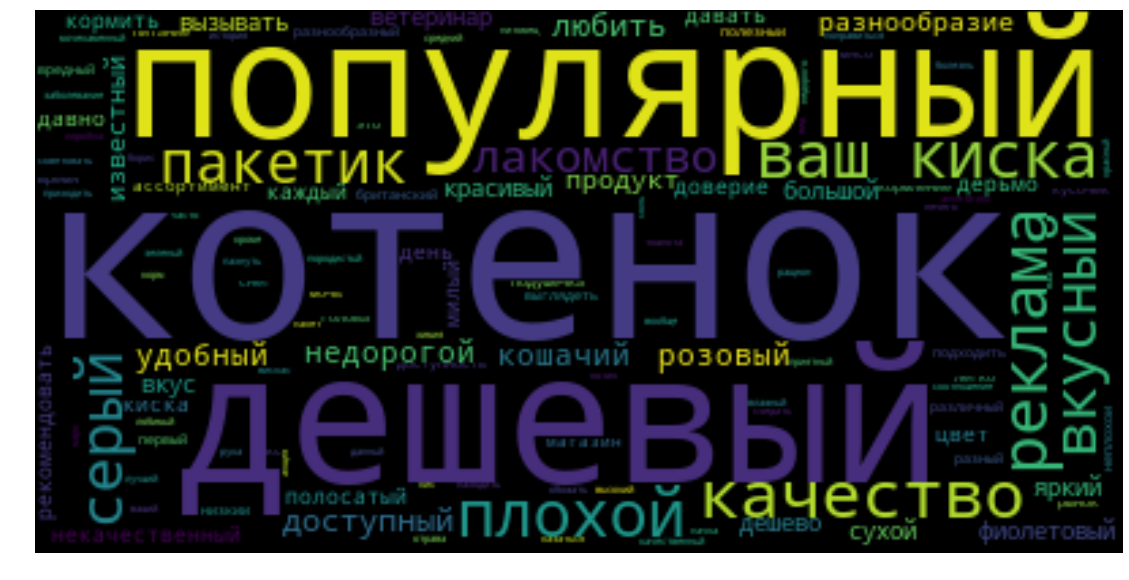

In [427]:
print('Just a test wordcloud for %s %s'%(cat_brands.iloc[3].category, cat_brands.iloc[3].brand))
text = cat_brands.text_cleaned[3]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

And another test wordcloud for CAT Kitekat


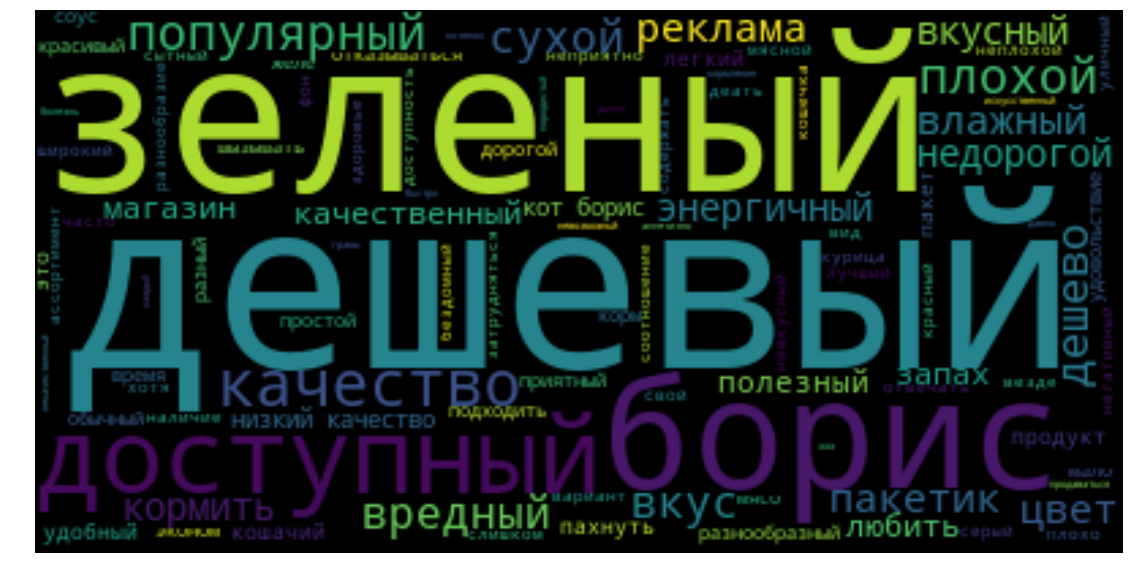

In [428]:
print('And another test wordcloud for %s %s'%(cat_brands.iloc[7].category, cat_brands.iloc[7].brand))
text = cat_brands.text_cleaned[7]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

And another test wordcloud for DOG Cesar


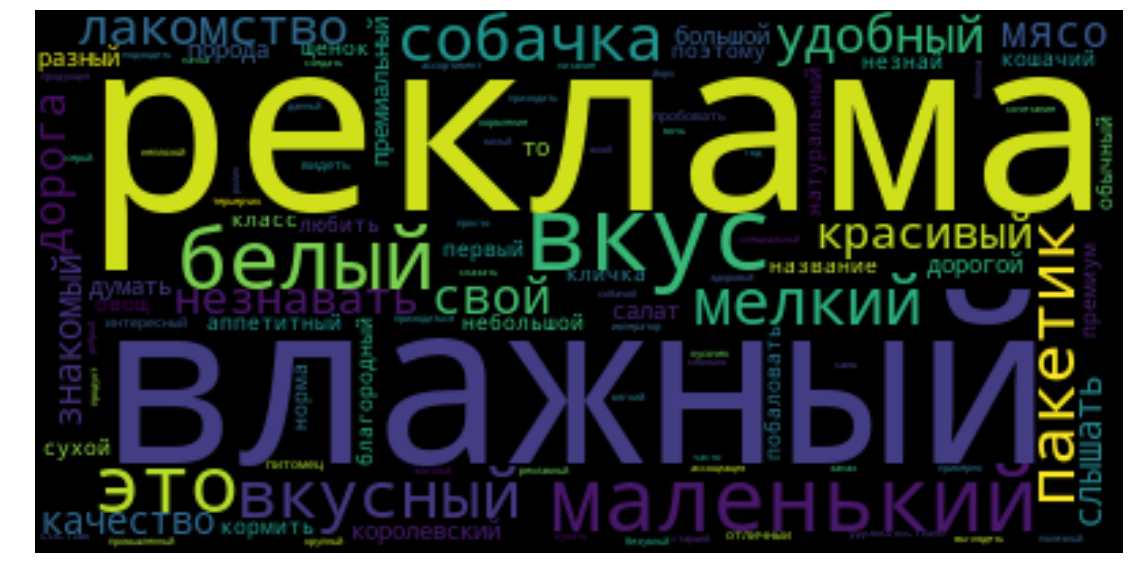

In [429]:
print('And another test wordcloud for %s %s'%(cat_brands.iloc[11].category, cat_brands.iloc[11].brand))
text = cat_brands.text_cleaned[11]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [431]:
# Snapshot
cat_brands.to_csv('cat_brands.csv', index=False)

In [6]:
cat_brands = pd.read_csv('cat_brands.csv')

### Let's upload masks for better looking word clouds

For wordcloud library we need to convert font into 255 numbers  
The second function loads prints word cloud and also saves it into a subfolder.

In [127]:
def transform_image_mask(img_name = 'cat_sit'):
    mask = np.array(Image.open('./silouettes/'+img_name+'.png'))
    initial_font_number = mask[0][0][0]
    transformed = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
    
    for x in range(len(mask)):
        transformed[x] = [255-i+initial_font_number for i in mask[x].T[1]]
    
    return transformed

def print_word_cloud(dataframe, img_name = 'cat_sit', category='CAT', brand='Whiskas', 
                     background_color="white", contour_color='purple', contour_width=2, max_words=1000):
    mask = transform_image_mask(img_name)
    
    wc = WordCloud(background_color=background_color, max_words=max_words, mask=mask, 
                   contour_width=contour_width, contour_color=contour_color)
    text = dataframe.loc[(dataframe.category==category)&(dataframe.brand==brand),'text_cleaned'].values[0]
    wc.generate(text)
    
    file_name = category+'_'+brand+'_wordcloud'+'.png'
    wc.to_file('word_clouds/'+file_name)
    
    plt.figure(figsize=[20,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(' '.join([category, brand,'wordcloud']))
    plt.show()

Se we'are geared and ready to draw our own unique word clouds!

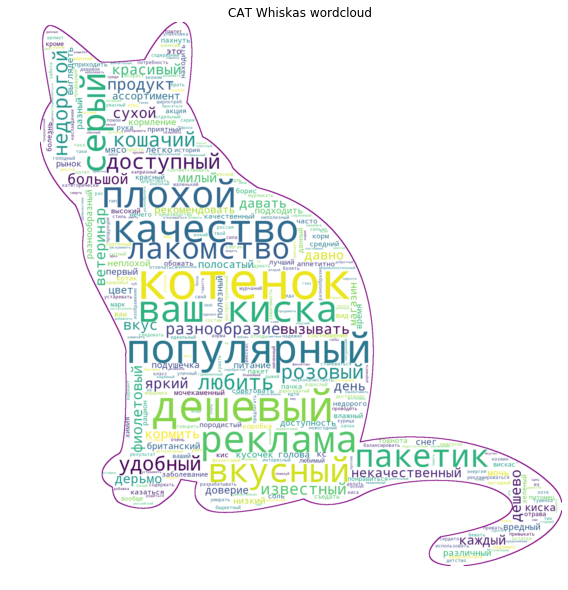

In [128]:
print_word_cloud(cat_brands, img_name = 'cat_sit', category='CAT', brand='Whiskas', 
                 background_color="white", contour_color='purple', contour_width=4, max_words=1000)

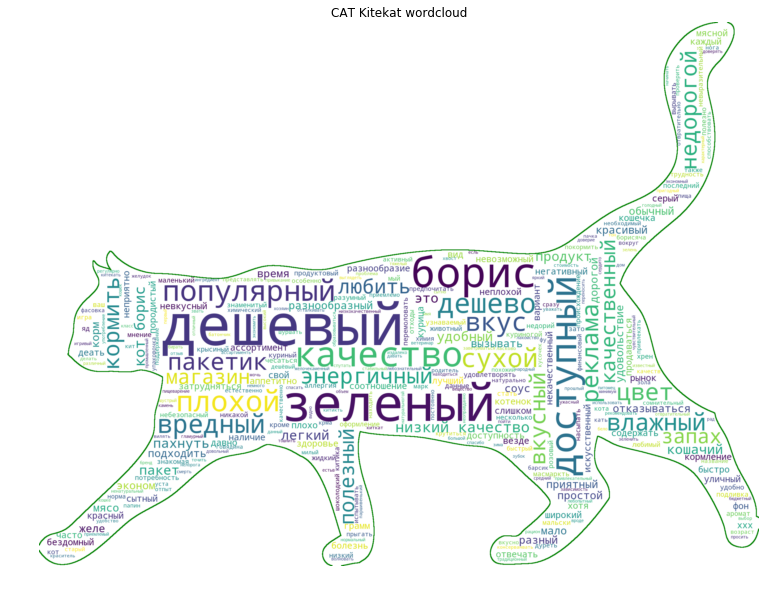

In [129]:
print_word_cloud(cat_brands, img_name = 'cat_walk', category='CAT', brand='Kitekat', 
                 background_color="white", contour_color='green', contour_width=4, max_words=1000)

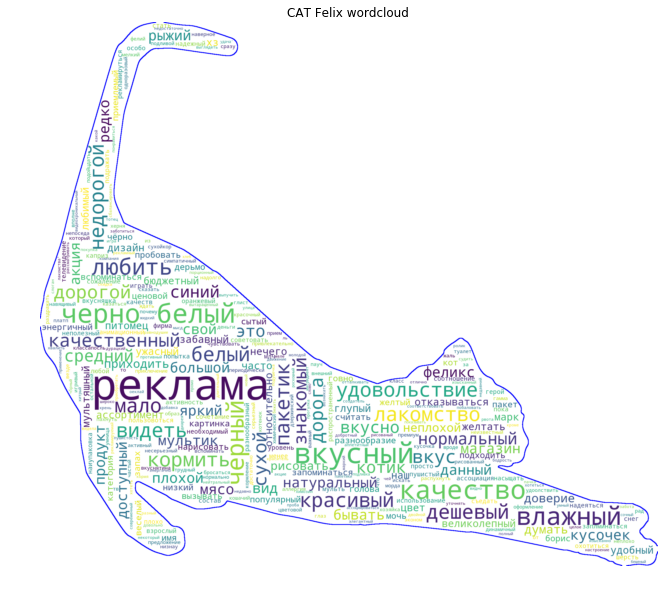

In [131]:
print_word_cloud(cat_brands, img_name = 'cat_stratch', category='CAT', brand='Felix', 
                 background_color="white", contour_color='blue', contour_width=4, max_words=1000)

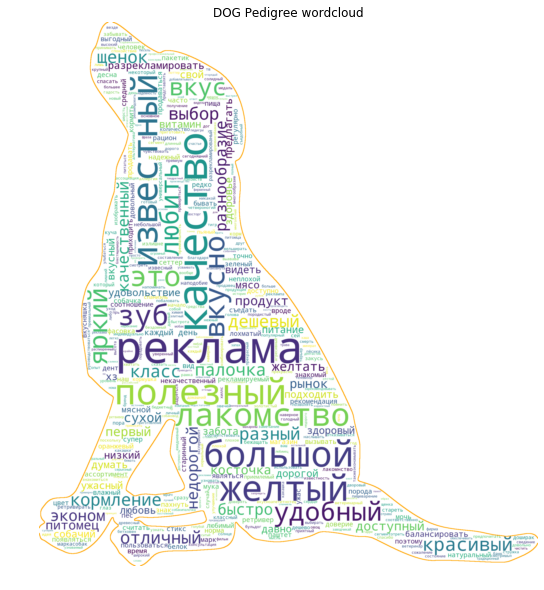

In [134]:
print_word_cloud(cat_brands, img_name = 'dog_sit', category='DOG', brand='Pedigree', 
                 background_color="white", contour_color='orange', contour_width=4, max_words=1000)

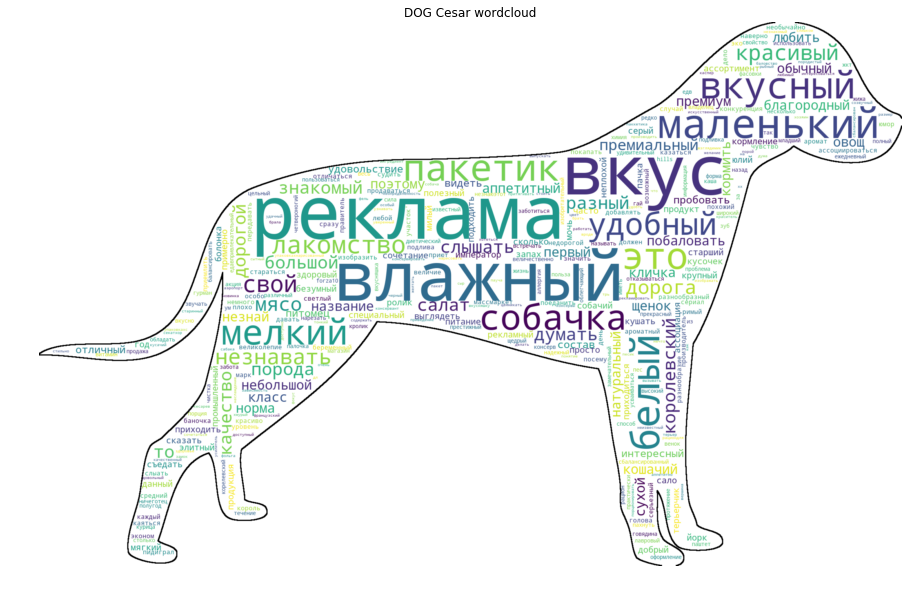

In [135]:
print_word_cloud(cat_brands, img_name = 'dog_stand', category='DOG', brand='Cesar', 
                 background_color="white", contour_color='black', contour_width=4, max_words=1000)

### At this point I finish this analysis. There is still some opportunities to make this work more precise, but hope this notebook is a good example of Machine Learning opportuniries in natural text processing.